In [1]:
from constants import SECONDS_PER_DAY, GENESIS_EPOCH, SLOTS_PER_HISTORICAL_ROOT, MAX_VALIDATORS_PER_COMMITTEE
from specs import (
    BeaconState, BeaconBlock, BeaconBlockHeader, BeaconBlockBody, SignedBeaconBlock,
    Deposit, DepositData, Checkpoint, AttestationData, Attestation,
    initialize_beacon_state_from_eth1, get_block_root, get_block_root_at_slot,
    process_slots, process_block,
    get_current_epoch, get_previous_epoch, compute_start_slot_at_epoch, compute_epoch_at_slot,
    get_total_active_balance, get_committee_assignment, get_active_validator_indices, is_valid_genesis_state
)
from ssz_impl import (hash_tree_root, signing_root)
from ssz_typing import Bitlist
from hash_function import hash
from eth2 import eth_to_gwei

import secrets

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

from cadCAD import configs

import pandas as pd
import matplotlib_inline

## Process with attestations

We create new policies to make validators attest on the blocks of the beacon chain. Attestations are "votes" in the FFG gadget, committing to checkpoints and beacon chain blocks. _All_ active validators are called on to produce one attestation during each epoch. Each validator is assigned to _one_ slot to make the attestation at, preferably right after they have received the block proposed for that slot.

So attestations should contain:
- A _source_ attribute: the last justified checkpoint the validator knows about.
- A _target_ attribute: the last non-justified checkpoint the validator knows about.
- A _head_ attribute: what the validator sees as the current tip of the beacon chain, preferably the block proposed for their assigned slot.
- A _slot_ attribute: the slot assigned to the validator.

Admittedly, we are cheating a bit here. Since we assume our validators are honest and there is no latency, they are instantly up-to-date with the latest chain state, so we can use the `BeaconState` attributes to form validator attestations. In reality, validators should run the fork choice to decide which is the head of the beacon chain.

We start at some state $\omega^+[s-1]$, i.e., the post-state of slot $s-1$.

1. **(State update)** We move the state from $\omega^+[s-1]$ to $\omega^-[s]$.
2. **(Policy)** Validators at state $\omega^-[s]$ make attestations for slot $s-1$. These attestations contain a source and target for their FFG vote and the head of the chain according to their view of the beacon chain (in this case, $b_{s-1}$).
3. **(State update)** These attestations are kept in the simulation state space as `current_slot_attestations`.
4. **(Policy)** Someone proposes a block $b_s$ at slot $s$. Note that $b_s$ contains attestations made by validators in committees at slot $s-1$, which are kept in `current_slot_attestations`.
5. **(State update)** The state transitions to $\omega^+[s]$ when the block is processed.

### Process slot

The arguments of this function are given to us by the cadCAD execution environment. `s` holds the current state of the simulation, where `s['beacon_state']` returns the current beacon state. Remember that we had set the initial state $\omega^+[0]$ as the `beacon_state` attribute of the `initial_conditions` dictionary.

In [2]:
# First we need to update the slot
# This is a state update function
def state_process_slots(_params, substep, sH, s, _input, **kwargs):
    
    state = s['beacon_state']
    process_slots(state=state, slot=state.slot + 1)

    return ('beacon_state', state)

### Attestation policy

Let's focus on the new step here, step \#2. We first need to create honest attestations from validators.

In [3]:
def attest(state, validator_index):

    # In Barnabe's code attestors attest to the block from the previous slot (having already 
    # processed that block, meaning it's cached).

    # Given state w-[s], validators in committees of slot `s-1` form their attestations
    # In several places here, we need to check whether `s` is the first slot of a new epoch.

    current_epoch = get_current_epoch(state)
    previous_epoch = get_previous_epoch(state)

    # We are assuming honest attesting only. 
    # Hence, we can assume that validators attesting during some epoch E, they choose the
    # first block of E as their target and the first block of E-1 as their source. 
    
    # We need to check that whether w-[s] is in a new epoch... 

    # If slot is in new epoch, remember that we want to attest to the block of the past epoch
    if state.slot == compute_start_slot_at_epoch(current_epoch):
        
        # Get committee assignment from slot s-1 in past epoch... 
        (committee, committee_index, committee_slot) = get_committee_assignment(
            state, previous_epoch, validator_index
            )
        block_root = get_block_root_at_slot(state, committee_slot)

        src_checkpoint = Checkpoint(
            epoch=state.previous_justified_checkpoint.epoch,
            root=state.previous_justified_checkpoint.root
        )

        tgt_checkpoint = Checkpoint(
            epoch=previous_epoch,
            # get_block_root() returns the blockroot at the start of a recent ``epoch``
            root=get_block_root(state, previous_epoch)
        )

    # slot s is still in same epoch as slot (s-1)
    else:
        # Get committee assignment from slot s-1 in past epoch... 
        (committee, committee_index, committee_slot) = get_committee_assignment(
            state, current_epoch, validator_index
            )
        block_root = get_block_root_at_slot(state, committee_slot)

        src_checkpoint = Checkpoint(
            epoch=state.current_justified_checkpoint.epoch,
            root=state.current_justified_checkpoint.root
        )

        tgt_checkpoint = Checkpoint(
            epoch=current_epoch,
            root=get_block_root(state, current_epoch)
        )

    att_data = AttestationData(
        slot=committee_slot,
        index=committee_index,
        beacon_block_root=block_root,
        source=src_checkpoint,
        target=tgt_checkpoint,
    )

    print("Attestation for source epoch {} and target epoch {}".format(src_checkpoint.epoch, tgt_checkpoint.epoch))

    committee_size = len(committee)
    index_in_committee = committee.index(validator_index)
    aggregation_bits = Bitlist[MAX_VALIDATORS_PER_COMMITTEE](*([0] * committee_size))
    aggregation_bits[index_in_committee] = True # set the aggregation bits of the validator to True
    attestation = Attestation(
        aggregation_bits=aggregation_bits,
        data=att_data
    )
    
    return attestation

We can use this `attest` function in our policy function for step \#2, `policy_attest`.

In [4]:
def policy_attest(_params, substep, sH, s, **kwargs):

    '''
    Collect all attestation formed for slot (s-1)
    '''

    state = s['beacon_state']
    current_epoch = get_current_epoch(state)
    previous_epoch = get_previous_epoch(state)

    # We are in a new epoch...
    if state.slot == compute_start_slot_at_epoch(current_epoch):
        validator_epoch = previous_epoch
    else: # We're still in the same epoch
        validator_epoch = current_epoch
    
    # Let's find out who was supposed to be attesting 
    active_validator_indices = get_active_validator_indices(state, validator_epoch)
    slot_attestations = [] # We'll store attestation in here

    # check for each validator which committee they belong to
    for validator_index in active_validator_indices:
        (committee, committee_index, committee_slot) = get_committee_assignment(
            state, validator_epoch, validator_index
        )
        # if validator belongs to committee supposed to attest, attest!
        if committee_slot+1 == state.slot: #remember we are attesting one slot late...
            print("Validator {} attesting for slot {}".format(validator_index, committee_slot))
            attestation = attest(state, validator_index)
            slot_attestations.append(attestation)

    return {'slot_attestations': slot_attestations}

### Keep attestations in state

Step \#3 is easily handled with one single state update.

In [5]:
def state_update_current_slot_attestations(_params, substep, sH, s, _input, **kwargs):
    # just dump the policy input into a state variable current_slot_attestations... 
    return('current_slot_attestations', _input['slot_attestations'])

### Block proposal policy

We must update our block proposal policy to include latest attestations. This time, we do not include offline block proposers.

In [6]:
d = {"apple": ("apple", 2), "banana": ("banana",5)}

In [7]:
a = []
print(a)
a += [1,2,3]
print(a)
a += [0,1,6]
print(a)

[]
[1, 2, 3]
[1, 2, 3, 0, 1, 6]


In [8]:
# Next we need a way to propose a block, which can then be processed (state update)
# This is a policy function
def policy_propose_block(_params, substep, sH, s, **kwargs):
    ''' 
    Given state w-[s], propose a block for slot s. 

    This time round we are including attestations in the beacon_block_body!
    '''
    
    state = s['beacon_state']
    attestations = s['current_slot_attestations']

    # Propose a block for slot s
    beacon_block_body = BeaconBlockBody(
        attestations=attestations
    )
    
    beacon_block = BeaconBlock(
        slot=state.slot,
        #proposer_index=,
        parent_root=get_block_root_at_slot(state, state.slot - 1), # to ensure this block is a direct child of last block processed
        # state_root= ,
        body=beacon_block_body
    )
    signed_beacon_block = SignedBeaconBlock(message=beacon_block)

    print("A validator proposed a block for slot {} (epoch: {})".format(state.slot, compute_epoch_at_slot(state.slot)))

    return {'block': signed_beacon_block}

### Process block

We also have a state update for this step, `state_process_block`, which we do not need to change.

In [9]:
def state_process_block(_params, substep, sH, s, _input, **kwargs):

    state = s['beacon_state']
    block = _input['block']

    # if block is None:
    #     # no change to the state
    #     return ('beacon_state', state)
    
    # Process block and update state
    process_block(state, block.message)

    return ('beacon_state', state)

## Putting it all together, PSUBs

The previous three steps are recorded in the `block_proposal_psub` array. `psub` stands for _partial state updates blocks_, the building blocks of a cadCAD simulation.

In [10]:
partial_state_update_blocks = [
    { #PSUB1
        "policies": {},
        "variables": {
            "beacon_state": state_process_slots
        }
    },
    { #PSUB2
        "policies": {
            "action": policy_attest
        },
        "variables": {
            "current_slot_attestations": state_update_current_slot_attestations
        }
    },
    { #PSUB3
        "policies": {
            "action": policy_propose_block
        },
        "variables": {
            "beacon_state": state_process_block
        }
    }
]

### Let's create a genesis state

In [11]:
# Initial deposits
def get_initial_deposits(n):
    return [Deposit(
        data=DepositData(
        amount=eth_to_gwei(32),
        pubkey=secrets.token_bytes(48))
    ) for i in range(n)]

In [12]:
# Create genesis state
number_validators = 10
some_string = "Actual string doesn't matter!"
block_hash = hash(some_string.encode("utf-8"))
eth1_timestamp = 1578009600

genesis_state = initialize_beacon_state_from_eth1(block_hash, eth1_timestamp, get_initial_deposits(number_validators))

In the specs, the first block is not proposed by a validator but obtained from the genesis state. We define a function to process the genesis block from the genesis state.

In [13]:
def process_genesis_block(genesis_state):
    genesis_block = SignedBeaconBlock(
        message=BeaconBlock(
            state_root=hash_tree_root(genesis_state),
            parent_root=hash_tree_root(genesis_state.latest_block_header)
        )
    )
    process_block(genesis_state, genesis_block.message)
    
process_genesis_block(genesis_state)

In [14]:
initial_conditions = {
    'beacon_state': genesis_state,
    'current_slot_attestations': []
}

simulation_parameters = {
    'T': range(20), # number of time steps
    'N': 1, # number of Monte Carlo runs
    'M': {} # parameter sweep
}

In [15]:
# configure cadCAD
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_conditions,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = simulation_parameters
)

In [16]:
# execute cadCAD
exec_mode = ExecutionMode() #
exec_context = ExecutionContext() # how to run simulation (single vs. multi threaded, etc.)
simulation = Executor(exec_context=exec_context, configs=configs)
# The `execute()` method returns a tuple; its first elements contains the raw results
raw_result, tensor, sessions = simulation.execute() 
df = pd.DataFrame(raw_result)

Initializing configurations: 100%|██████████| 1/1 [00:00<00:00, 171.67it/s]
                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (20, 0, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded

Validator 1 attesting for slot 0
Attestation for source epoch 0 and target epoch 0
Validator 5 attesting for slot 0
Attestation for source epoch 0 and target epoch 0
A validator proposed a block for slot 1 (epoch: 0)
if-statement: target epoch: 0, source epoch: 0, current_justified_checkpoint epoch: 0, previous_justified_checkpoint epoch: 0
if-statement: target epoch: 0, source epoch: 0, current_justified_checkpoint epoch: 0, previous_justified_checkpoint

In [17]:
sum(df.iloc[0]['beacon_state'].balances)==sum(df.iloc[60]['beacon_state'].balances)

True

In [18]:
df

,beacon_state,current_slot_attestations,simulation,subset,run,substep,timestep
0,BeaconState\n genesis_time: 1578182400\n slo...,[],0,0,1,0,0
1,BeaconState\n genesis_time: 1578182400\n slo...,[],0,0,1,1,1
2,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,2,1
3,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,3,1
4,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,1,2
...,...,...,...,...,...,...,...
56,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,2,19
57,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,3,19
58,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,1,20
59,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,2,20


In [19]:
df["num_attestations"] = df[df.substep==1].current_slot_attestations.apply(len)
df["epoch"] = df[df.substep==1].beacon_state.apply(get_current_epoch)
df[df.substep==1].iloc[:,5:] #slices df: only shows column with index >=5

,substep,timestep,num_attestations,epoch
1,1,1,0.0,5.0
4,1,2,2.0,5.0
7,1,3,3.0,5.0
10,1,4,2.0,5.0
13,1,5,3.0,5.0
16,1,6,2.0,5.0
19,1,7,3.0,5.0
22,1,8,2.0,5.0
25,1,9,3.0,5.0
28,1,10,2.0,5.0


In [20]:
df.iloc[60]['beacon_state'].balances

List[Gwei, 1099511627776](32014707826, 32014707826, 32014820963, 32014255278, 32014934100, 32014255278, 32014029004, 32014820963, 32014255278, 32014029004)

In [21]:
df.iloc[60]['beacon_state'].finalized_checkpoint

{'epoch': 3, 'root': b'\xfc\xf3\x1d\xecI=\xe9\x07u\x05\xe6T1\rw\x00C\x96\x1cxk\xa1h\x0fp\xa4\xbf\xe1a\x8ey$'}

In [22]:
df['total_balance'] = df.beacon_state.apply(
    lambda state: sum(state.balances) - eth_to_gwei(32 * number_validators)
)

In [23]:
df['total_balance']

0     144815520
1     144815520
2     144815520
3     144815520
4     144815520
        ...    
56    144815520
57    144815520
58    144815520
59    144815520
60    144815520
Name: total_balance, Length: 61, dtype: int64

In [24]:
%matplotlib inline

<AxesSubplot:xlabel='timestep'>

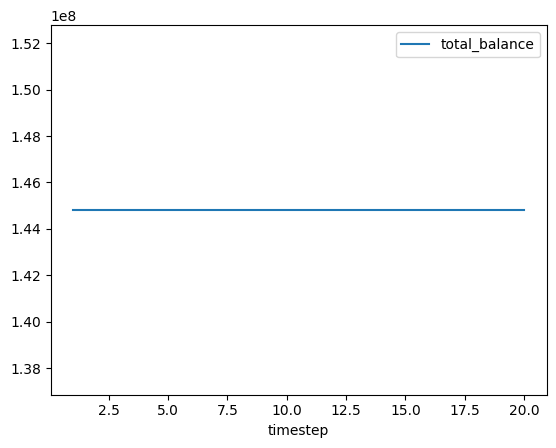

In [25]:
df[df.substep == 1].plot('timestep', 'total_balance')